In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.signal import fftconvolve

# Part 1 Template Matching NCC

In [2]:
search = imread('./data/search.png')
template = imread('./data/template.png')

In [3]:
image_shape = search.shape

image = np.array(search, dtype=np.float64, copy=False)

In [4]:
pad_width = tuple((width, width) for width in template.shape)

In [5]:
image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=0)

In [6]:
def calc_window_sum(image, window_shape):
    window_sum = np.cumsum(image, axis=0)
    window_sum = (window_sum[window_shape[0]:-1] - window_sum[:-window_shape[0] - 1])
    window_sum = np.cumsum(window_sum, axis=1)
    window_sum = (window_sum[:, window_shape[1]:-1] - window_sum[:, :-window_shape[1] - 1])
    window_sum = np.cumsum(window_sum, axis=2)
    window_sum = (window_sum[:, :, window_shape[2]:-1] - window_sum[:, :, :-window_shape[2] - 1])
    return window_sum

In [7]:
image_window_sum = calc_window_sum(image, template.shape)
image_window_sum2 = calc_window_sum(image ** 2, template.shape)

In [8]:
template_mean = template.mean()
template_volume = np.prod(template.shape)
template_ssd = np.sum((template - template_mean) ** 2)

In [9]:
xcorr = fftconvolve(image, template[::-1, ::-1, ::-1], mode="valid")[1:-1, 1:-1, 1:-1]

In [10]:
numerator = xcorr - image_window_sum * template_mean

In [11]:
denominator = image_window_sum2

In [12]:
image_window_sum = np.multiply(image_window_sum, image_window_sum)

In [13]:
image_window_sum = np.divide(image_window_sum, template_volume)

In [14]:
denominator -= image_window_sum
denominator *= template_ssd

In [15]:
denominator = np.maximum(denominator, 0) # sqrt of negative number not allowed

In [16]:
denominator = np.sqrt(denominator)

In [17]:
response = np.zeros_like(xcorr, dtype=np.float64)

In [18]:
mask = denominator > np.finfo(np.float64).eps

In [19]:
response[mask] = numerator[mask] / denominator[mask]

In [20]:
slices = []

In [21]:
for i in range(template.ndim):
    d0 = template.shape[i] - 1
    d1 = d0 + image_shape[i] - template.shape[i] + 1
    slices.append(slice(d0, d1))

In [22]:
result = response[tuple(slices)]

In [31]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [32]:
ind = largest_indices(result, 500)

In [23]:
ij = np.unravel_index(np.argmax(result), result.shape)
_, x, y = ij[::-1] # IMPORTANT TO SWITCH ROWS AND COLUMUNS I've LOST 5 points this semester because of this

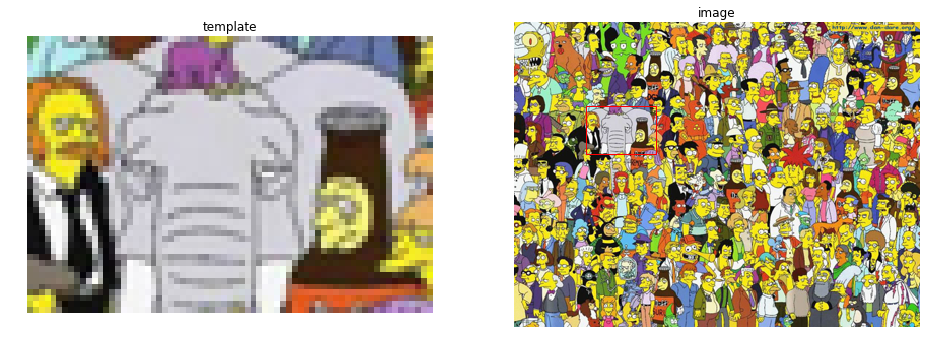

In [28]:
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(template)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(search)
ax2.set_axis_off()
ax2.set_title('image')

htemplate, wtemplate, _ = template.shape

rect = plt.Rectangle((x, y), wtemplate, htemplate, edgecolor='r', facecolor='none')

ax2.add_patch(rect)

plt.show()

# Part 2 Template Matching Stereo Vision

In [36]:
left = imread('./data/left.png')
right = imread('./data/right.png')

In [72]:
def calc_window_sum_2d(image, window_shape):
    window_sum = np.cumsum(image, axis=0)
    window_sum = (window_sum[window_shape[0]:-1] - window_sum[:-window_shape[0] - 1])
    window_sum = np.cumsum(window_sum, axis=1)
    window_sum = (window_sum[:, window_shape[1]:-1] - window_sum[:, :-window_shape[1] - 1])
    return window_sum

In [82]:
def matchTemplate(image, template):
    pad_width = tuple((width, width) for width in template.shape)
    image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=0)
    image_window_sum = calc_window_sum_2d(image, template.shape)
    image_window_sum2 = calc_window_sum_2d(image ** 2, template.shape)
    template_mean = template.mean()
    template_volume = np.prod(template.shape)
    template_ssd = np.sum((template - template_mean) ** 2)
    xcorr = fftconvolve(image, template[::-1, ::-1], mode="valid")[1:-1, 1:-1]
    numerator = xcorr - image_window_sum * template_mean
    denominator = image_window_sum2
    image_window_sum = np.multiply(image_window_sum, image_window_sum)
    image_window_sum = np.divide(image_window_sum, template_volume)
    denominator -= image_window_sum
    denominator *= template_ssd
    denominator = np.maximum(denominator, 0) # sqrt of negative number not allowed
    denominator = np.sqrt(denominator)
    response = np.zeros_like(xcorr, dtype=np.float64)
    mask = denominator > np.finfo(np.float64).eps
    response[mask] = numerator[mask] / denominator[mask]
    slices = []
    for i in range(template.ndim):
        d0 = template.shape[i] - 1
        d1 = d0 + image_shape[i] - template.shape[i] + 1
        slices.append(slice(d0, d1))
    result = response[tuple(slices)]
    return result

In [89]:
def disparity_ncorr(L, R, block_size=5, disparity_range=30, lambda_factor=0):
    im_rows, im_cols = L.shape
    tpl_rows = tpl_cols = block_size
    D_L = np.zeros(L.shape, dtype=np.float32)

    for r in range(tpl_rows//2, im_rows-tpl_rows//2):
        tr_min, tr_max = max(r-tpl_rows//2, 0), min(r+tpl_rows//2+1, im_rows)
        for c in range(tpl_cols//2, im_cols-tpl_cols//2):
            # get template
            tc_min = max(c-tpl_cols//2, 0)
            tc_max = min(c+tpl_cols//2+1, im_cols)
            tpl = L[tr_min:tr_max, tc_min:tc_max].astype(np.float32)
            # get R strip in a window with width=disparity_range
            rc_min = max(c-disparity_range//2, 0)
            rc_max = min(c+disparity_range//2+1, im_cols)
            R_strip = R[tr_min:tr_max, rc_min:rc_max].astype(np.float32)
            # find best match of template in strip
            error = matchTemplate(R_strip, tpl)
            #c_tf = max(c-rc_min-tpl_cols//2, 0)
            #dist = np.arange(error.shape[1]) - c_tf
            #cost = error - np.abs(dist * lambda_factor)
            ij = np.unravel_index(np.argmax(error), error.shape)
            x, y = ij[::-1] 
            D_L[r, c] = error[x, y]
    return D_L

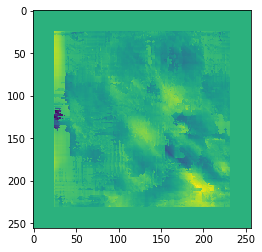

In [93]:
plt.imshow(disparity_ncorr(left, right, block_size=50, disparity_range=50))

# Part 3 k-Nearest-Neighbours